In [ ]:
%pip install pyautogen

In [ ]:
%pip install pandas

In [ ]:
%pip install seaborn

In [1]:
import warnings
from dotenv import load_dotenv

load_dotenv()
warnings.filterwarnings('ignore')

In [10]:
import autogen
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image # 주피터 안에서 이미지를 시각화 해주는 IPython.display을 활용

from autogen.coding import LocalCommandLineCodeExecutor

config_list = [{"model": "gpt-4o-mini"}]
llm_config = {"config_list": config_list}

### 멀티에이전트를 그룹챗으로 구현
- 실제로 인터넷에 있는 정보를 가져와 데이터를 시각화 구현

In [14]:

# 멀티에이전트를 그룹챗으로 만들기
# 그룹챗을 만들때 user_proxy에이전트랑 coder만 있으면, user_proxy에이전트는 coder가 짜준 코드만 실행할 뿐이다.
# 하지만 user_proxy가  어떤 버그가 났을 때 그거를 고치기 위한 역할을 coder가 수행할 수도 있지만,
# 그런데 coder가 모든 역할을 수행하게 되면 코드를 작성하는데 과부화가 와서 제대로 보완하지 못 할 수도 있다.
# 그래서 critic에이전트를 통해 이 부분을 보완할 수 있게 3개의 에이전트가 유기적으로 잘 수행하게끔 만들었다.
# 실제로 인터넷에 있는 정보를 가져와 데이터를 시각화 했다. AutoGen의 멀티에이전트 시스템이 꽤나 강력하다는 걸 볼 수 있다.

# user_proxy: 코드를 실행하는 주최로써 user_proxy 에이전트를 실행
user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.", # 지금은 어떤 것을 넣어도 상관없음. user_proxy에이전트가 이 코드를 실행하기 이전에 아래 AssistantAgent가 줬던것을 판단해서 실행하는 역할을 맡고 있기 때문에 "A human admin"이라는 시스템 메세지만 넣어줌
    code_execution_config={
        # the executor to run the generated code
        "executor": LocalCommandLineCodeExecutor(work_dir="group_chat"),
    },
    human_input_mode="NEVER", 
)

# 코딩을 담당하는 어시스턴트 에이전트
coder = autogen.AssistantAgent(
    name="Coder",  # the default assistant agent is capable of solving problems with code
    llm_config=llm_config,
)

# coder에이전트가 생성한 코드를 비평하는 비평가 에이전트
critic = autogen.AssistantAgent(
    name="Critic",
    system_message="""비평가. 
    명확한 근거를 제시하면서 1(나쁨)~10(좋음)의 점수를 제공하여 주어진 시각화 코드의 품질을 평가하는 데 고도로 숙련된 조력자입니다. 
    각 평가에 대해 시각화 모범 사례를 고려해야 합니다. 구체적으로 다음 차원에서 코드를 신중하게 평가할 수 있습니다.
- 버그(버그): 버그, 구문 오류 또는 오타가 있나요? 코드가 컴파일되지 않는 이유는 무엇인가요? 어떻게 수정해야 하나요? 
버그가 있는 경우 버그 점수는 반드시 5점 미만이어야 합니다.
- 데이터 변환(변환): 데이터가 시각화 유형에 맞게 적절하게 변환되었나요? 
예를 들어, 필요한 경우 데이터 집합이 적절하게 필터링, 집계 또는 그룹화되었는가? 날짜 필드를 사용하는 경우, 날짜 필드가 먼저 날짜 개체 등으로 변환되었는가?
- 목표 준수(규정 준수): 코드가 지정된 비주얼리제이션 목표를 얼마나 잘 충족합니까?
- 시각화 유형(유형): 모범 사례를 고려할 때 시각화 유형이 데이터 및 의도에 적합한가? 
인사이트를 전달하는 데 더 효과적인 시각화 유형이 있는가? 다른 시각화 유형이 더 적절하다면 점수는 반드시 5점 미만이어야 합니다.
- 데이터 인코딩(인코딩): 데이터가 시각화 유형에 맞게 적절하게 인코딩되어 있습니까?
- 미학(심미성): 시각화의 미학이 시각화 유형 및 데이터에 적합한가?

위의 각 차원에 대해 점수를 제공해야 합니다.
{bugs: 0, 변환: 0, 규정 준수: 0, type: 0, encoding: 0, 미학: 0}
코드를 제안하지 마세요.
마지막으로 위의 비평을 바탕으로 코더가 코드를 개선하기 위해 취해야 할 구체적인 조치 목록을 제안하세요.
""",
    llm_config=llm_config,
)

groupchat = autogen.GroupChat(agents=[user_proxy, coder, critic], messages=[], max_round=20) # 20라운드 내에서 제대로된 데이터 시각화를 수행할 수 있도록 설정
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)

In [12]:
# user_proxy부터 대화를 시작할 것이다.
user_proxy.initiate_chat(
    manager,
    message="""다음 URL(https://github.com/mwaskom/seaborn-data/blob/master/titanic.csv)에서 데이터를 다운로드하고, 
    age와 pclass 변수 간의 관계를 차트로 생성해주세요. 차트는 파일로 저장해주세요. 
    차트를 생성하기 이전에 확인을 위해 데이터셋의 열을 출력하세요.
    """,
)
# type exit to terminate the chat

User_proxy (to chat_manager):

다음 URL(https://github.com/mwaskom/seaborn-data/blob/master/titanic.csv)에서 데이터를 다운로드하고, 
    age와 pclass 변수 간의 관계를 차트로 생성해주세요. 차트는 파일로 저장해주세요. 
    차트를 생성하기 이전에 확인을 위해 데이터셋의 열을 출력하세요.
    

--------------------------------------------------------------------------------

Next speaker: Coder

Coder (to chat_manager):

우선, 주어진 URL에서 데이터를 다운로드하고, 이후 데이터셋의 열을 출력한 뒤, `age`와 `pclass` 변수 간의 관계를 차트로 생성하겠습니다. 

1. 데이터셋을 다운로드합니다.
2. 데이터셋의 열을 출력합니다.
3. `age`와 `pclass` 변수 간의 관계를 차트로 생성하여 파일로 저장합니다.

이런 방식으로 진행하겠습니다. 아래의 파이썬 코드를 실행해 주세요.

```python
# filename: plot_age_pclass.py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 다운로드
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv"
data = pd.read_csv(url)

# 데이터셋의 열 출력
print(data.columns.tolist())

# 'age'와 'pclass' 변수 간의 관계 차트 생성
plt.figure(figsize=(10, 6))
sns.boxplot(x='pclass', y='age', data=data)
plt.title('Age vs Pclass')
plt.xlabel('Pclass')
plt.ylab

ChatResult(chat_id=None, chat_history=[{'content': '다음 URL(https://github.com/mwaskom/seaborn-data/blob/master/titanic.csv)에서 데이터를 다운로드하고, \n    age와 pclass 변수 간의 관계를 차트로 생성해주세요. 차트는 파일로 저장해주세요. \n    차트를 생성하기 이전에 확인을 위해 데이터셋의 열을 출력하세요.\n    ', 'role': 'assistant', 'name': 'User_proxy'}, {'content': '우선, 주어진 URL에서 데이터를 다운로드하고, 이후 데이터셋의 열을 출력한 뒤, `age`와 `pclass` 변수 간의 관계를 차트로 생성하겠습니다. \n\n1. 데이터셋을 다운로드합니다.\n2. 데이터셋의 열을 출력합니다.\n3. `age`와 `pclass` 변수 간의 관계를 차트로 생성하여 파일로 저장합니다.\n\n이런 방식으로 진행하겠습니다. 아래의 파이썬 코드를 실행해 주세요.\n\n```python\n# filename: plot_age_pclass.py\nimport pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# 데이터 다운로드\nurl = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv"\ndata = pd.read_csv(url)\n\n# 데이터셋의 열 출력\nprint(data.columns.tolist())\n\n# \'age\'와 \'pclass\' 변수 간의 관계 차트 생성\nplt.figure(figsize=(10, 6))\nsns.boxplot(x=\'pclass\', y=\'age\', data=data)\nplt.title(\'Age vs Pclass\')\nplt.xlabel(\'Pclass\')\nplt.ylabel(\'Age\

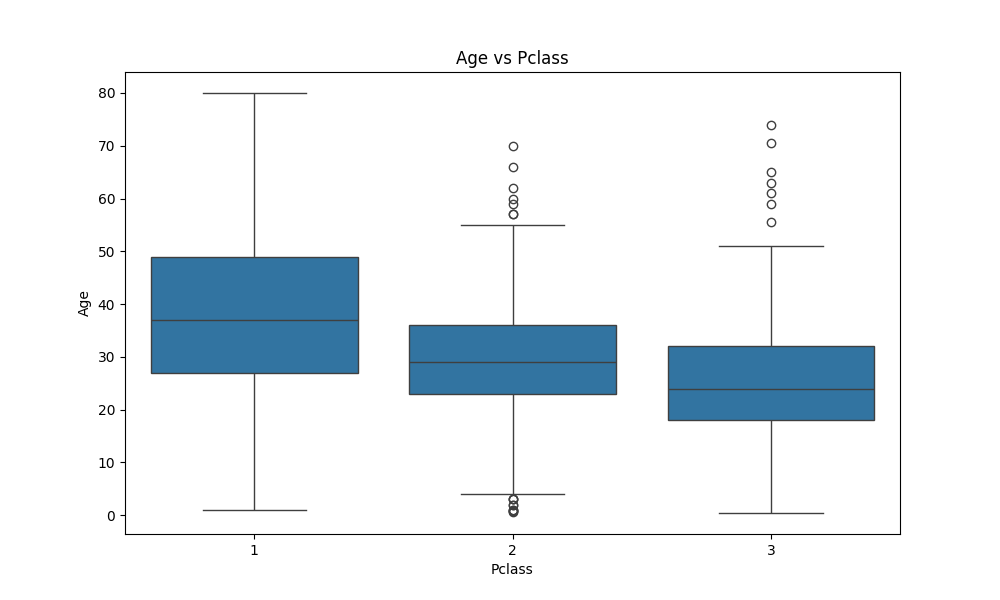

In [24]:
Image(filename="group_chat/age_vs_pclass.png") # group_chat폴더 안에 있는 age_vs_pclass.png 파일을 시각화 해줌